# Data analysis

This notebook contains the routines used for the analysis of the January 2023 run data, employed on the reduced data (output of the 2dfdr pipeline, see [here](https://aat.anu.edu.au/files/2dF-AAOmega-obs-manual_4.pdf) for the manual which also describes the fits output format in sec. 16.1).

**WARNING**: It is still very messy and experimental and not necessary for the setup of the target files!

In [24]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pathlib import Path
import verfu_tool as vt
import aat_clusters_scripts as acs

def check_var(infile, remove_neg=True):
 
# open FITS file:
    hdulist = fits.open(infile, mode='update')
        
    # get the variance:
    var = hdulist['VARIANCE'].data
 
    # do some stats on the variance array:
    print('min/max variance value:',np.nanmin(var),np.nanmax(var))
    # index of pixels that have negative variance;
    negidx = np.where(var < 0.0)
    print(negidx)
 
    # set -ve values to Nan:
    if (remove_neg):
        var[negidx] = np.nan
 
    
    hdulist.close()

fpath = "./data/data_analysis/Cluster-2/19feb20024red.fits"
fpath = "./data/data_analysis/Cluster-18/Cluster-18_erosita_run010_v19_19.fits"
# check_var(fpath)

hdulist =  fits.open(fpath)
hdulist.info()
main_hdu = hdulist["PRIMARY"]

wl_min, wl_delta, wl_unit = main_hdu.header["CRVAL1"], main_hdu.header["CDELT1"], main_hdu.header["CUNIT1"]
wl_max = main_hdu.header["NAXIS1"]*wl_delta + wl_min
wl_grid = np.arange(wl_min, wl_max, wl_delta)
main_hdu.header

Filename: ./data/data_analysis/Cluster-18/Cluster-18_erosita_run010_v19_19.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     185   (5056, 400)   float32   
  1  VARIANCE      1 ImageHDU         8   (5056, 400)   float32   
  2  FIBRES        1 BinTableHDU    106   400R x 17C   [80A, 1D, 1D, 1J, 1J, 1I, 1I, 1D, 1A, 1I, 1D, 1J, 80A, 10A, 1D, 1D, 1D]   
  3  NDF_CLASS     1 BinTableHDU     11   1R x 1C   [10A]   
  4  SHIFTS        1 ImageHDU         8   (400, 10)   float64   
  5  THPUT         1 ImageHDU         7   (400,)   float32   
  6  RWSS          1 ImageHDU         8   (2048, 400)   float32   
  7  SKY           1 ImageHDU         7   (5056,)   float32   
  8  TELCOR        1 ImageHDU         7   (2048,)   float32   
  9  REDUCTION_ARGS    1 TableHDU        15   100R x 2C   [A16, A32]   
 10  REDUCED       1 BinTableHDU     11   1R x 1C   [1L]   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / No of bits per pixel data                      
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 5056 / length of data axis 1                          
NAXIS2  =                  400 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the end of each substring which is then continued        
COMMENT   on the next keywor

62


name,ra,dec,x,y,xerr,yerr,theta,type,pivot,magnitude,pid,comment,retractor,wlen,pmra,pmdec,spectrum
bytes80,float64,float64,int32,int32,int16,int16,float64,bytes1,int16,float64,int32,bytes80,bytes10,float64,float64,float64,float32[5056]
EROSOURCE_967209455191902,3.895838871500708,-0.4273345104467662,-6738,20621,8,-4,0.018266,P,3,17.848,0,--,74,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192851,3.897177684481092,-0.42608616369927726,10291,36499,11,7,0.250837,P,12,17.6,0,--,52,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192013,3.895975588958781,-0.42637167047608265,6163,21985,-8,-5,0.374917,P,21,18.127,0,--,43,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192118,3.8961181241810268,-0.42672063936374527,1538,23811,-12,2,0.458197,P,27,18.392,0,--,43,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192258,3.896326109250223,-0.4278169970222064,-13046,26688,3,1,0.460942,P,30,18.275,0,--,43,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192652,3.8969420650320723,-0.4284738225973736,-21641,34388,0,-3,0.557012,P,36,17.882,0,--,86,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192176,3.896213390069365,-0.42834335923578704,-20091,25501,-9,-11,0.703966,P,45,18.207,0,--,84,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192641,3.8969311567242477,-0.42920487314711864,-31396,34498,-14,-7,0.710296,P,46,18.394,0,--,84,600.0,0.0,0.0,nan .. nan
EROSOURCE_967209455192155,3.8961704840585867,-0.42888053279445637,-27278,25155,-7,-12,0.826709,P,53,17.719,0,--,55,600.0,0.0,0.0,nan .. nan


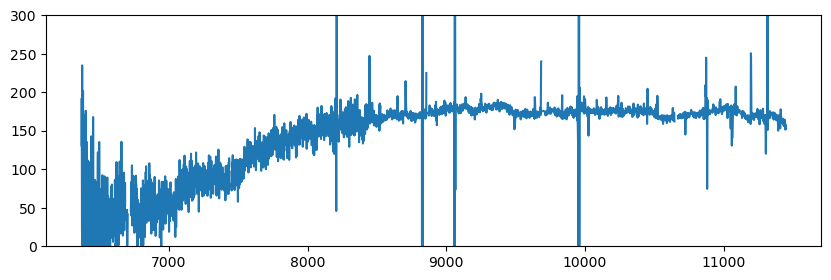

In [13]:
fibres = Table.read(fpath, hdu=2)
fibres.rename_columns((cols := fibres.colnames), [col.lower() for col in cols])
fibres["spectrum"] = main_hdu.data
my_fibres = fibres[["EROSOURCE" in name for name in fibres["name"]]]
# for spec in my_fibres["spectrum"]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(wl_grid, np.sum(my_fibres["spectrum"], axis=0)/len(my_fibres))
ax.set_ylim(0, 300)
print(len(my_fibres))

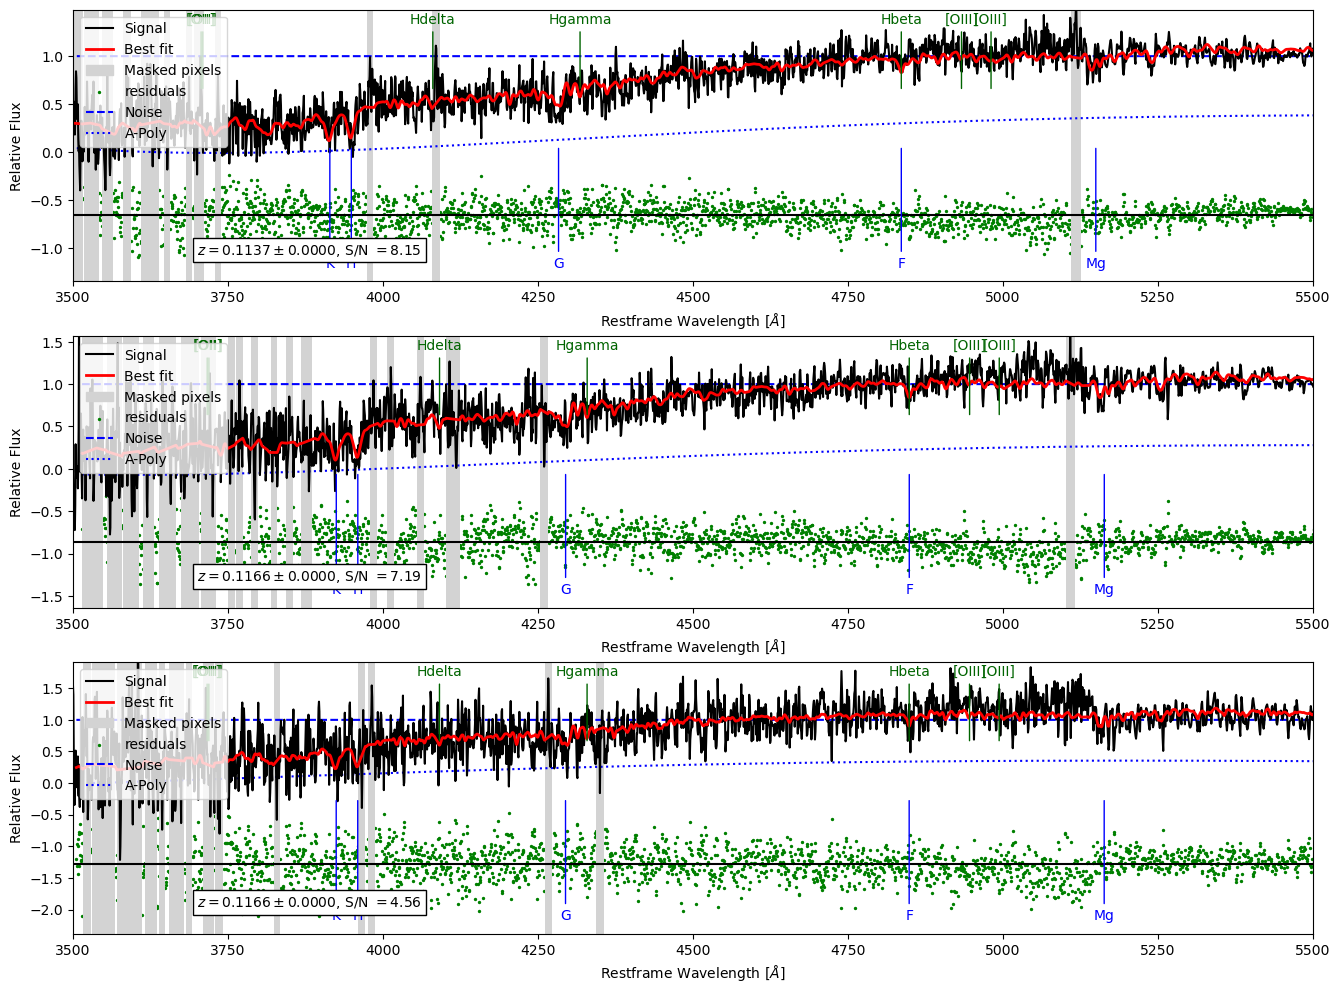

In [208]:
# For my use case, I am looking at clusters.
ALL_CLUSTERS = Table.read(acs.PATHS.clusters)
ALL_CLUSTERS.add_index("mem_match_id")
this_cluster = ALL_CLUSTERS.loc[-1855905442]

def read_observation_fits(fpath: Path) -> tuple[dict, Table]:
    hdulist =  fits.open(fpath)
    main_hdu = hdulist["PRIMARY"]

    # Extract wavelength information:
    wl_ref, wl_delta, wl_unit = main_hdu.header["CRVAL1"], main_hdu.header["CDELT1"], main_hdu.header["CUNIT1"]
    ref_pix = main_hdu.header["CRPIX1"]
    wl_min = wl_ref - wl_delta*(ref_pix-1)  # TODO: Ask whether this is the right approach!
    wl_max = main_hdu.header["NAXIS1"]*wl_delta + wl_min
    wl_grid = np.arange(wl_min, wl_max, wl_delta)
    fibres = Table.read(fpath, hdu=2)
    fibres.rename_columns((cols := fibres.colnames), [col.lower() for col in cols])
    fibres["spectrum"] = main_hdu.data
    fibres["variance"] = hdulist["VARIANCE"].data
    fwhm = main_hdu.header["DISPERS"]*3  # TODO: Ask if this is appropriate to use as FWHM! Wasn't sure here
    info_dict = {"wl_grid": wl_grid, "fwhm": fwhm, "wl_unit": wl_unit}
    fibres.add_index("name")
    return info_dict, fibres


fpath = "./data/data_analysis/Cluster-18/Cluster-18_erosita_run010_v19_18.fits"
# fpath = "./data/data_analysis/Cluster-18/18feb10028red.fits"
WL_INFO, FIBRES = read_observation_fits(fpath)
my_fibres = FIBRES[["EROSOURCE" in name for name in FIBRES["name"]]][:3]
my_fibres.sort("magnitude")


# spec = my_fibres[my_fibres["name"] == "EROSOURCE_967209455190610"][0]["spectrum"]
z_initial = this_cluster["best_z"]+0.01


num_plots = len(my_fibres)

fig, axes = plt.subplots(num_plots, 1, figsize=(16, 4*num_plots))
redshifts = {}
for ax, member in zip(axes, my_fibres):
    spec = member["spectrum"]
    spec = np.nan_to_num(spec, 0) / np.nanmedian(spec)
    cont = vt.PpxfContainer(spec, z_initial, wl_parameters=WL_INFO, sigmaclip_value=3.5, goodpixel_range=(200, 4600))
    cont.perform_simple_ppxf()
    cont.plot(ax, True)
    ax.set_xlim(3500, 5500)
    redshifts[member["name"]] = cont.z_best
my_fibres["z_best"] = redshifts

# variance = my_fibres["variance"][0]
# # variance = np.nan_to_num(variance, 0) / np.nanmedian(variance)
# ax.plot(WL_INFO["wl_grid"]/(1+cont.z_best), variance)
# print(np.nanmin(variance), np.nanmax(variance))

In [204]:
my_fibres["z_best"] = list(redshifts.values())
my_fibres["z_best"]

0.11206526609155687
0.11949180374597779
0.11206526609155687
0.11499639449697185
0.11366546926303767
0.11306576572603522
0.11206526609155687
0.11206526609155687
0.11826247098169285
0.11990683773122313
0.11206526609155687


In [195]:


fpath = "./data/data_analysis/Cluster-18/Cluster-18_erosita_run010_v19_18.fits"
# fpath = "./data/data_analysis/Cluster-18/18feb10028red.fits"
WL_INFO, FIBRES = read_observation_fits(fpath)
my_fibres = FIBRES[["EROSOURCE" in name for name in FIBRES["name"]]]
print(WL_INFO, len(my_fibres))
ids_1 = np.unique(my_fibres["name"])
fpath = "./data/data_analysis/Cluster-18/Cluster-18_erosita_run010_v19_19.fits"
WL_INFO, FIBRES = read_observation_fits(fpath)
my_fibres = FIBRES[["EROSOURCE" in name for name in FIBRES["name"]]]
print(WL_INFO, len(my_fibres))
ids_2 = np.unique(my_fibres["name"])
len(np.intersect1d(ids_1, ids_2))

{'wl_grid': array([3720.00025404, 3721.04080119, 3722.08134833, ..., 8977.88498006,
       8978.92552721, 8979.96607435]), 'fwhm': 4.7049015814695, 'wl_unit': 'Angstroms'} 62
{'wl_grid': array([3720.00025404, 3721.04080119, 3722.08134833, ..., 8977.88498006,
       8978.92552721, 8979.96607435]), 'fwhm': 4.7049015814695, 'wl_unit': 'Angstroms'} 62


57